<a href="https://colab.research.google.com/github/PanavShah1/deep_learning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classfication is a problem of predicting whether something is one thing or another (there can be multiple things as the options)


## 1. Make classfication data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


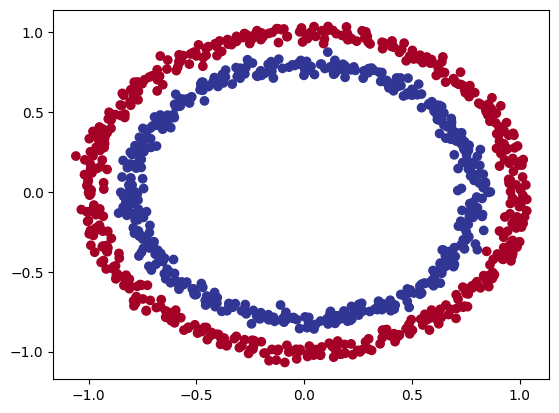

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


**Note**: The data we're working with is often refereed to as a toy dataset, a dataset that is small enough to experiment with but still sizable enough to proactice the fundamentals

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} adn the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) adn the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [ ]:
# 1. Construct a model that subclasses nn.Module

class CircleModeV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and ourputs a single feature (same as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModeV0().to(device)
model_0

CircleModeV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions : {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
  print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
  print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions : 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regressing you might want MAE or MSE (mean absolute error or mean square error)

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function mesures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* Common choices of loss functions and optimizers
* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`
* Logit
* Different optimizers



In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss requires inputs to have gone through a sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

To train our model, we need to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation functions (e.g. sigmoid for binary classfication and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits o turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 2)


In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilites as input
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropogation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test loss: 0.69262, Test acc: 53.00%


## 4. Make predictions and evalueate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and visualise it.

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


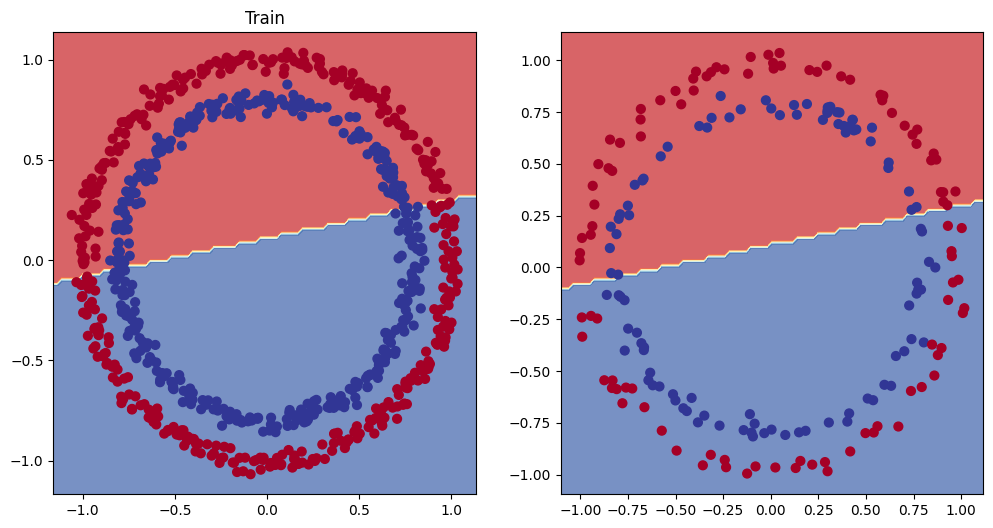

In [ ]:
# Plot decision boudary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving our model (from a model perspective)

* Add more layers - give the model more chances to learn about pattens in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activating functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the data.

And because these options are all values we can change, they are referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units : 5->10
* Increase the number of layers : 2->3
* Increase the number of epchs: 100->1000


In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [ ]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropogation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out whats happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


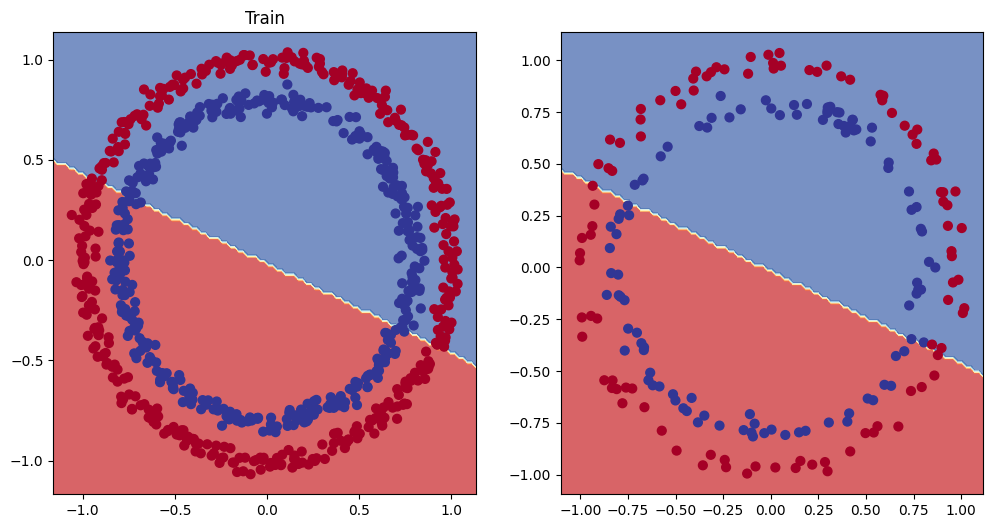

In [ ]:
# Plot decision boudary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# Create some date (same as notebool 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

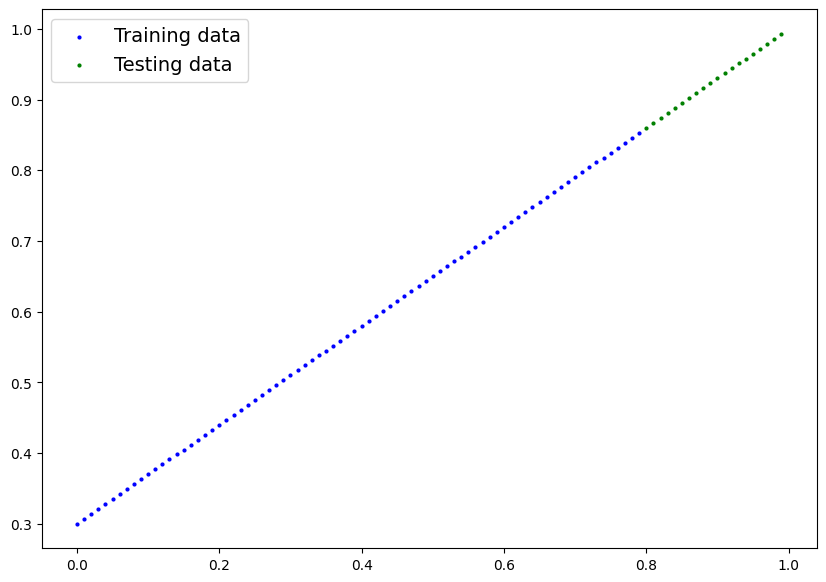

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of eopchs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.5f} | Test loss : {test_loss:.5f}")

Epoch : 0 | Loss : 0.75986 | Test loss : 0.91103
Epoch : 100 | Loss : 0.02858 | Test loss : 0.00081
Epoch : 200 | Loss : 0.02533 | Test loss : 0.00209
Epoch : 300 | Loss : 0.02137 | Test loss : 0.00305
Epoch : 400 | Loss : 0.01964 | Test loss : 0.00341
Epoch : 500 | Loss : 0.01940 | Test loss : 0.00387
Epoch : 600 | Loss : 0.01903 | Test loss : 0.00379
Epoch : 700 | Loss : 0.01878 | Test loss : 0.00381
Epoch : 800 | Loss : 0.01840 | Test loss : 0.00329
Epoch : 900 | Loss : 0.01798 | Test loss : 0.00360


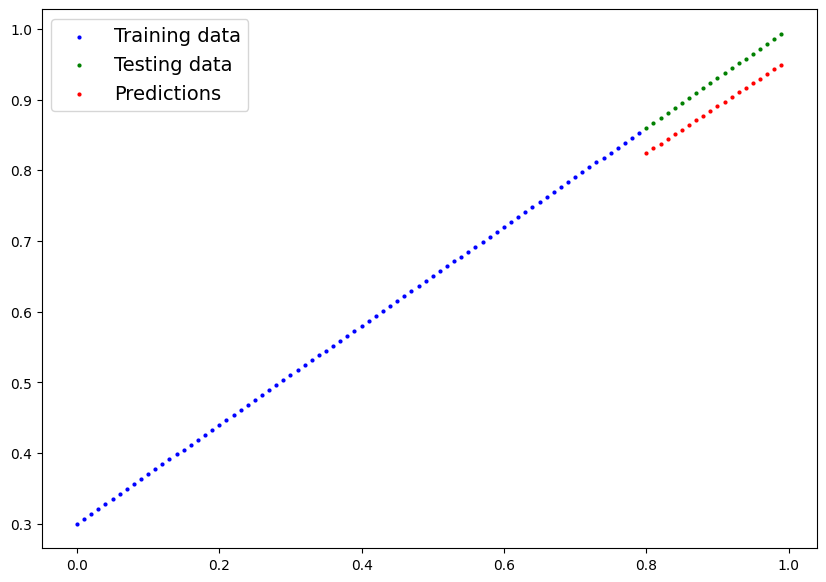

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and nonstraight lines?"

Or in machine learning terms, an infinite(but really it's finite) of linear and non-linear functions?


### 6.1 Recreating non-linear data (red and blue circles)

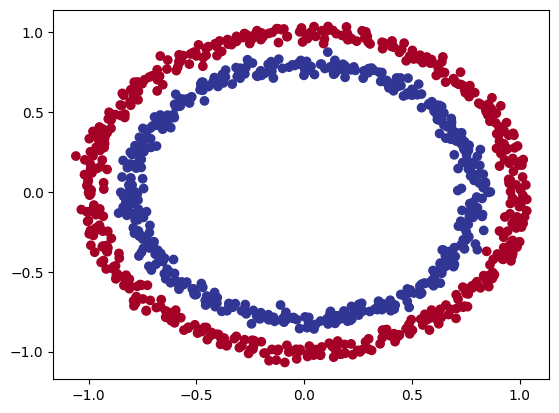

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non Linear = not a straight line

In [ ]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # ReLU is a non linear activation function

  def forward(self, x):
    # Where should we put our non linear activation function
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                               lr=0.1)


In [ ]:
### 6.3 Training a model with non linearity

# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Put all data on the target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()


  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929 | Acc: 50.00% | Test Loss: 0.6932 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912 | Acc: 52.88% | Test Loss: 0.6910 | Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898 | Acc: 53.37% | Test Loss: 0.6894 | Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879 | Acc: 53.00% | Test Loss: 0.6872 | Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852 | Acc: 52.75% | Test Loss: 0.6841 | Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810 | Acc: 52.75% | Test Loss: 0.6794 | Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751 | Acc: 54.50% | Test Loss: 0.6729 | Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666 | Acc: 58.38% | Test Loss: 0.6632 | Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516 | Acc: 64.00% | Test Loss: 0.6476 | Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236 | Acc: 74.00% | Test Loss: 0.6215 | Test Acc: 79.00%


### 6.4 Evaluating a model with non-linear activating functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

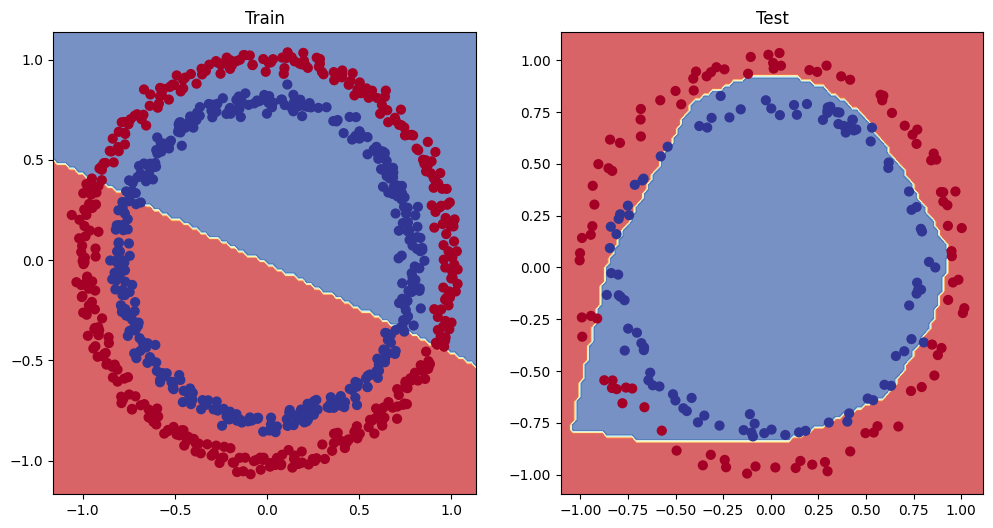

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**Improving the model**

## 7. Replicating non-linear activating functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the pattens on its own.

And these tools are linear & non linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

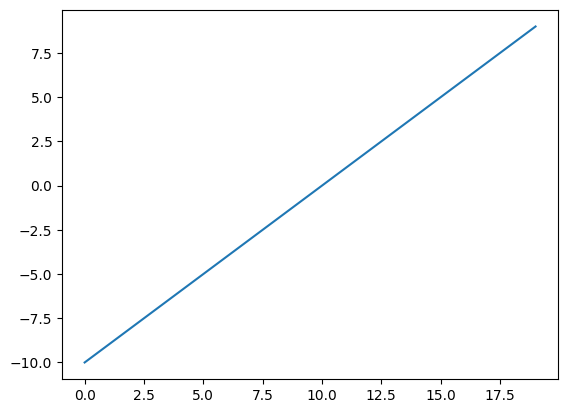

In [ ]:
# Visualise the tensor
plt.plot(A)

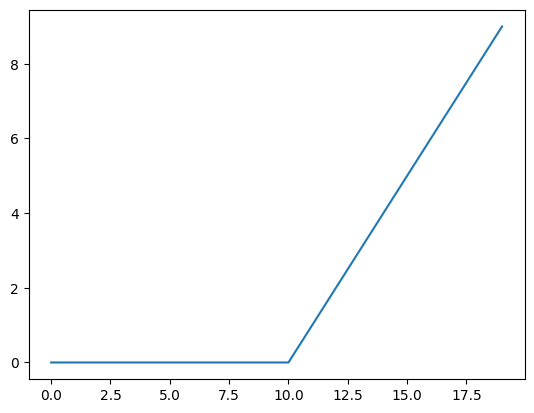

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

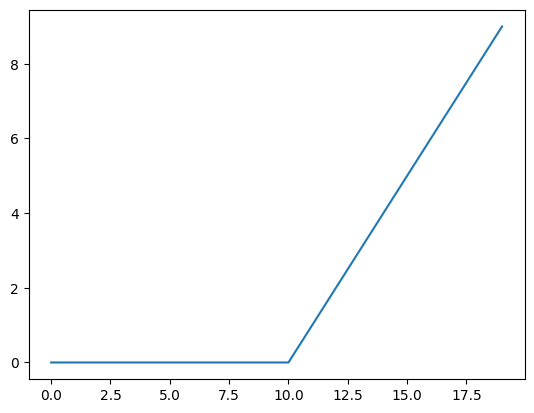

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

In [ ]:
# Now let's do the same for Sigmoid
def sigmoid(x):
  return (1 / (1 + torch.exp(-x)))



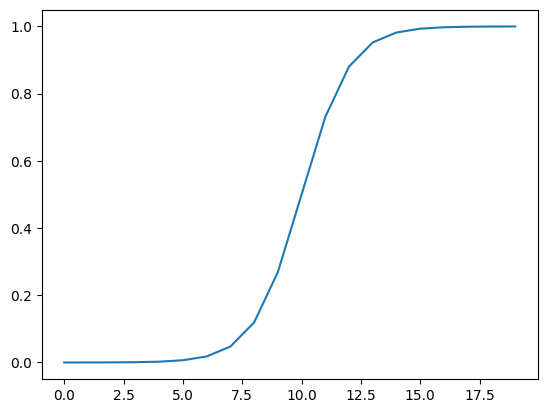

In [ ]:
plt.plot(torch.sigmoid(A))

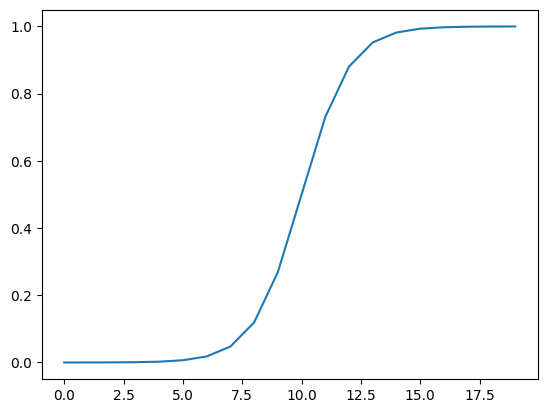

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another
* Multi-class classification = more than one thing

### 8.1 Creating a toy multi-class dataset

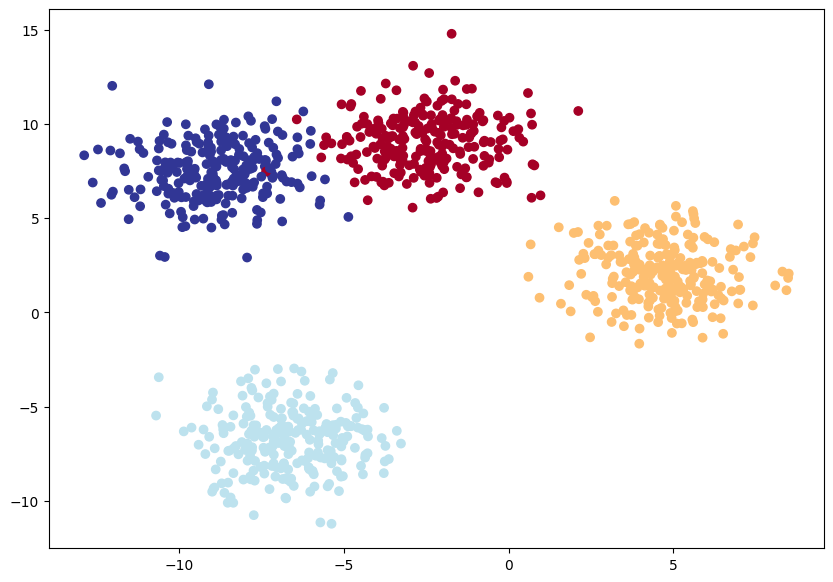

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input features (int): Number of input eatures to the model
      output features (int): Number of output features (number of output classes)
      hiddel_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)


In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
torch.unique(y_blob_train) # 4 classes

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and optimizer for a multi-class classification model

In [ ]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


### 8.4 Getting prediction probabilities for a mulit-class PyTorch model

In order to evaluate and train and test our model, we need to convdert our model's outputs (logits) to prediction probabilities and then turn to prediction labels

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# Convert our model's logit outputs to prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [ ]:
# Convert our model's prediiction probabilites to prediction labels
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create a training and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

  # Printing out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.1588 | Acc: 40.38 | Test loss: 1.0755 | Test acc: 21.00
Epoch: 10 | Loss: 0.6448 | Acc: 96.75 | Test loss: 0.6607 | Test acc: 21.00
Epoch: 20 | Loss: 0.4254 | Acc: 98.50 | Test loss: 0.4307 | Test acc: 21.00
Epoch: 30 | Loss: 0.2529 | Acc: 99.12 | Test loss: 0.2451 | Test acc: 21.00
Epoch: 40 | Loss: 0.1123 | Acc: 99.25 | Test loss: 0.1023 | Test acc: 21.00
Epoch: 50 | Loss: 0.0663 | Acc: 99.25 | Test loss: 0.0585 | Test acc: 21.00
Epoch: 60 | Loss: 0.0507 | Acc: 99.25 | Test loss: 0.0429 | Test acc: 21.00
Epoch: 70 | Loss: 0.0430 | Acc: 99.25 | Test loss: 0.0349 | Test acc: 21.00
Epoch: 80 | Loss: 0.0384 | Acc: 99.25 | Test loss: 0.0299 | Test acc: 21.00
Epoch: 90 | Loss: 0.0352 | Acc: 99.25 | Test loss: 0.0266 | Test acc: 21.00


In [ ]:
y_pred[:10], y_blob_train[:10]

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0'),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0'))

### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [ ]:
# Go from logits -> pred prob
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [ ]:
# Go from pred prob -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

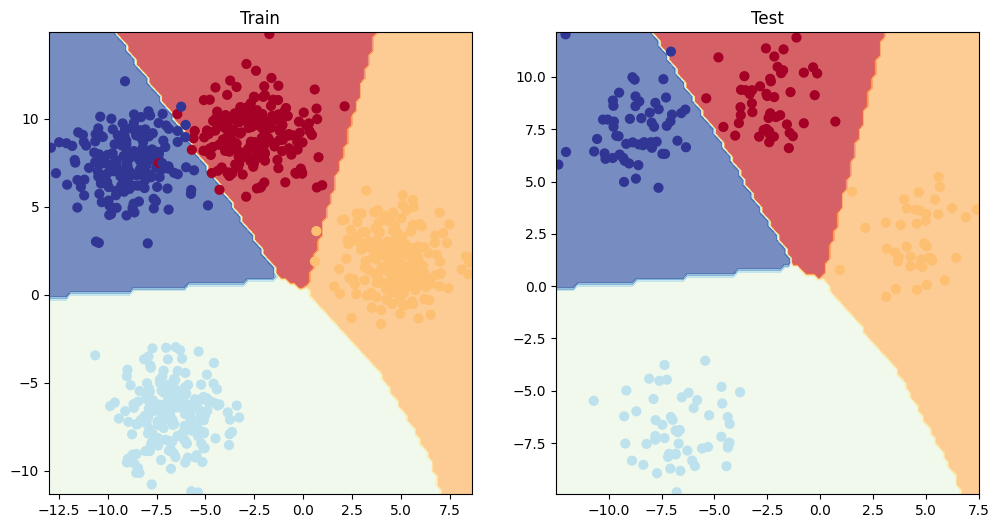

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of a 100 samples, how many does our model get right
* Precision
* Recall
* F1-score
* Classification report

See this article for when to use precion and recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to alot of PyTorch metrics, see TorchMetrics - https://readthedocs.org/projects/torchmetrics/

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [ ]:
torchmetric_accuracy.device

device(type='cuda', index=0)